In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:

# Loading the Fashion-MNIST dataset
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw


Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Examine a sample
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


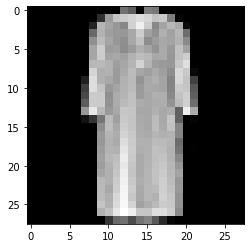

In [ ]:
plt.imshow(images[1].numpy().squeeze(), cmap = 'Greys_r')

In [ ]:
# Define the network architecture
from torch import nn, optim
import torch.nn.functional as F

model = nn.Sequential(nn.Linear(784, 650),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(650, 420),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(420, 360),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(360, 230),
                      nn.ReLU(),
                      nn.Dropout(0.2),
                      nn.Linear(230, 10),
                      nn.LogSoftmax(dim = 1)
                     )

In [ ]:
# Define the loss
criterion = nn.NLLLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [ ]:
# Define the epochs
epochs = 30

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    # Flatten Fashion-MNIST images into a 784 long vector
    images = images.view(images.shape[0], -1)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in testloader:
        images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
    print("Epoch: {}/{}..".format(e+1, epochs),
          "Training loss: {:.3f}..".format(running_loss/len(trainloader)),
          "Test loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30.. Training loss: 0.607.. Test loss: 0.528.. Test Accuracy: 0.818
Epoch: 2/30.. Training loss: 0.482.. Test loss: 0.432.. Test Accuracy: 0.848
Epoch: 3/30.. Training loss: 0.442.. Test loss: 0.421.. Test Accuracy: 0.850
Epoch: 4/30.. Training loss: 0.428.. Test loss: 0.412.. Test Accuracy: 0.855
Epoch: 5/30.. Training loss: 0.408.. Test loss: 0.389.. Test Accuracy: 0.861
Epoch: 6/30.. Training loss: 0.403.. Test loss: 0.398.. Test Accuracy: 0.862
Epoch: 7/30.. Training loss: 0.396.. Test loss: 0.399.. Test Accuracy: 0.859
Epoch: 8/30.. Training loss: 0.389.. Test loss: 0.391.. Test Accuracy: 0.866
Epoch: 9/30.. Training loss: 0.388.. Test loss: 0.400.. Test Accuracy: 0.863
Epoch: 10/30.. Training loss: 0.382.. Test loss: 0.367.. Test Accuracy: 0.878
Epoch: 11/30.. Training loss: 0.374.. Test loss: 0.372.. Test Accuracy: 0.869
Epoch: 12/30.. Training loss: 0.369.. Test loss: 0.387.. Test Accuracy: 0.859
Epoch: 13/30.. Training loss: 0.369.. Test loss: 0.383.. Test Accuracy: 0

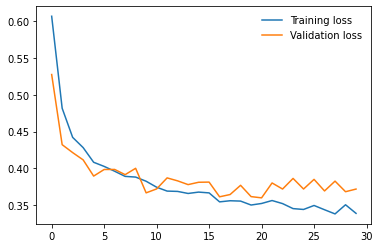

In [ ]:

plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)

In [ ]:
# Define view_classify function
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

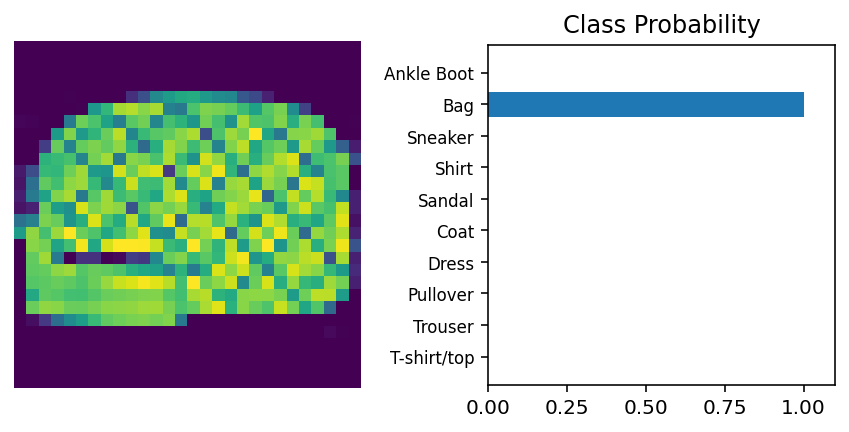

In [ ]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Testing out the network
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Calculate the class probabilites (log softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilites
view_classify(img, ps, version='Fashion')

In [ ]:
print("My model: \n\n", model, "\n")
print("The state dict keys: \n\n", model.state_dict().keys())

My model: 

 Sequential(
  (0): Linear(in_features=784, out_features=650, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=650, out_features=420, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=420, out_features=360, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=360, out_features=230, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=230, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
) 

The state dict keys: 

 odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias', '12.weight', '12.bias'])


In [ ]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [ ]:
state_dict = torch.load("checkpoint.pth")
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '9.weight', '9.bias', '12.weight', '12.bias'])


In [ ]:
# Load the state dict to the network
model.load_state_dict(state_dict)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=650, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=650, out_features=420, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=420, out_features=360, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=360, out_features=230, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
  (12): Linear(in_features=230, out_features=10, bias=True)
  (13): LogSoftmax(dim=1)
)
